# K Means Clustering: An Iterative Approach

Given a dataset *d*, automatically segment *d* such that data points fall into *k* number distinct clusters. 

A cluster is defined as any data group which demonstrates greater in-group similarity than out-of-group similarity. In other words, members of a cluster share commonalities among features which do not necessarily extend to members of other clusters. 

How does one measure feature "commonalities"? There are various methods. In this notebook, Euclidean distance among data points plotted in feature space will be used as the similarity metric. 

First, some housekeeping. 

In [142]:
# Reset the workspace, forcibly deleting all existing variables 
%reset -f

In [143]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from random import randint
from math import sqrt
from IPython import display

### Importing the Data

The set that will be used in this demo is a .csv file located in a subdirectory named Data. This script would theroretically work with any two-dimensional dataset, that is, any .csv containing data points plottable using two coordinates.

In [144]:
# Load data into a pandas dataframe
df = pd.read_csv('../Data/mall_customers.csv')

In [145]:
# Shall we shuffle the dataset? This is not strictly necessary for k means clustering. 
shuffle_on = False
if shuffle_on:
    df = df.sample(frac=1)

In [146]:
# Print data dimensionality to get our bearings. Then display first few rows
print('Numpy shape:', df.shape)
print('Number of data examples:', df.shape[0])
print('Number of data featrues:', df.shape[1])
print('Number of dimensions:', df.ndim)
df.head()

Numpy shape: (200, 5)
Number of data examples: 200
Number of data featrues: 5
Number of dimensions: 2


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [147]:
# Display summary statistics of the data. This includes basics like mean, min, max, and standard deviation
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [148]:
# Define dataset from existing dataframe
x = df['Age'].to_numpy()
y = df['Annual Income (k$)'].to_numpy()

print(type(x), type(y)) # Resultant variables are numpy arrays

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [149]:
# Set desired number of clusters (any positive integer > 0)
k = 4

### Step I: Initialize Centroids
Randomly select the starting locations of the cluster centers (a.k.a., "centroids"). 

There will be as many centroids as desired clusters (equal to *k*, defined above). 

We will also visualize the centroids (see below). 

In [150]:
def initialize_centroids(x_data, y_data, k):
    """
    Randomly instantiate centroids and return their coordinates in separate lists containing x and y components.
    
    Generates k number centroids at random locations within range of the data, which is 
    calculated and then reduced by 20%. This reduction is specified by the local variable
    'margin' and prevents cluster centroids from instantiating at the edge of the set, which 
    is less than optimal for the k means algorithm. 

    Args:
        x_data (numpy.ndarray): data for independent variable.
        y_data (numpy.ndarray): data for dependent variable.
        k (int): desired number of centroids/clusters.

    Returns:
        initial_centroids_x_coords: a list of length k, where each element is the x-coordinate of a centroid.
        initial_centroids_y_coords: a list of length k, where each element is the y-coordinate of a centroid.

    """
    x_max = np.amax(x_data) 
    x_min = np.amin(x_data)
    y_max = np.amax(y_data)
    y_min = np.amin(y_data)
    margin = 0.20 # Precludes centroids at edge of data range
    
    initial_centroids_x_coords = [] # List of all centroids' x coordinates
    initial_centroids_y_coords = [] # List of all centroids' y coordinates

    for i in range(k):
        initial_centroids_x_coords.append(randint(x_min, x_max)*(1-margin))
        initial_centroids_y_coords.append(randint(y_min, y_max)*(1-margin))

    return initial_centroids_x_coords, initial_centroids_y_coords

# Set number of clusters 
initial_centroids_x, initial_centroids_y = initialize_centroids(x, y, k)
print('Centroid coordinates:')
for j in range(k):
    print(initial_centroids_x[j],', ', initial_centroids_y[j], sep='')
    
print(type(initial_centroids_x), type(initial_centroids_y))
print(len(initial_centroids_x))

Centroid coordinates:
28.8, 92.80000000000001
23.200000000000003, 43.2
22.400000000000002, 56.0
21.6, 85.60000000000001
<class 'list'> <class 'list'>
4


In [151]:
# %matplotlib inline
# # Visualize data (grey) and starting centroid locations (red)
# figure(facecolor='w')
# plt.scatter(x, y, s=20, color='grey')
# plt.scatter(initial_centroids_x, initial_centroids_y, s = 30, color='red', marker='x')
# plt.title('Age vs. Income')
# plt.xlabel('Age (Years)')
# plt.ylabel('Income (Dollars)')
# plt.show()

In [152]:
# Make an empty numpy array of size (k, len(x)) to store distances to centroids
# Build in extra raw for the minimum distance value
d = np.zeros([k + 1, len(x)])
d.shape
print(type(d))

<class 'numpy.ndarray'>


### Step II: Assign Each Data Point to its Nearest Centroid
Remember, in this notebook, our metric will be Euclidean Distance. 

i. First find the distance between every combination of points and centroids.

ii. For each data point, identify the centroid whose distance is smallest.

iii. Assign every data point to its nearest centroid (identified in ii). Centroids and their member data points will be stored in a dictionary, to be returned by the function make_clusters. 

In [153]:
def find_distance(x1, y1, x2, y2):
    """
    Find Euclidean distance between a point (x1, y1) and another point (x2, y2).
    
    In the context of k means clustering, for a given set containing data points of the form (x1, y1),
    find the distance between every point in that set and every centroid (x2, y2).

    Args:
        x1 (int or float): x coordinate of first point.
        y1 (int or float): y coordinate of first point.
        x2 (int or float): x coordinate of second point.
        y2 (int or float): y coordinate of second point.

    Returns:
        distance: as a float. 

    """
    distance = sqrt((x1 - x2)**2 + (y1 - y2)**2)
    return distance

In [154]:
# Construct array d containing distances from every point to every centroid
# Rows (except last) = distances from data points to each centroid k_n
# Last Row of d = min(column), ie distances of data points to closes centroid
# Col of d = distance from datapoint m to each centroid k_n, min is last row

def make_clusters(x, y, k_x, k_y, d):
    """
    Create clusters by assigning each data point to its nearest centroid. 
    
    1. Find the Euclidean distance between every point described by (x,y) and every centroid (k_x, k_y).
    2. For each point, compare distances to find the nearest centroid. 
    3. Assign each point to the nearest centroid. 
    4. Return clusters as a dictionary, where keys are centroid coords and values are lists of member coords. 
    
    Args:
        x (numpy.ndarray): contains x coordinate of every data point
        y (numpy.ndarray): contains y coordinate of every data point
        k_x (list): contains x coordinate of every centroid
        k_y (list): contains y coordinate of every centroid 
        d (numpy.ndarray): null array of size (k+1, len(x)). Will store centroid distances

    Returns:
        clusters (dict): 
            keys: tuples containing centroid coordinates in the form (k_x, k_y)
            values: lists containing assigned member points' coordinates as tuples of the form (x, y)

    """
    k = len(initial_centroids_x) # Number of centroids 
    
    clusters = {}
    for j in range(len(x)): #200
        min_distance = 9999999999 # Arbitrarily large number 
        x_i, y_i = x[j], y[j] # Select (x, y) coords of one data point at a time
        for i in range(0, k): # k = number of clusters
            k_xi, k_yi = k_x[i], k_y[i] # Coordinates of each centroid  
            distance = find_distance(x_i, y_i, k_xi, k_yi)
            if distance < min_distance:
                min_distance = distance 
                centroid_coords = k_xi, k_yi
            d[i,j] = distance

        try: 
            clusters[centroid_coords].append(tuple([x_i, y_i]))
        except KeyError:
            clusters[centroid_coords] = [tuple([x_i, y_i])]

        # Uncomment below to see a printout of data points and their nearest centroids. 
        # print("Datapoint:",j,", x:",x_i,", y:",y_i,", Minimum distance:",min_distance, ", Nearest_centroid:", centroid_coords)

        col = d[:k,j]
        alt_min_distance = np.amin(col)
        d[k,j] = alt_min_distance
        
    return clusters

clusters = make_clusters(x, y, initial_centroids_x, initial_centroids_y, d)
print('TYPE of clusters:',type(clusters))
print(clusters.keys())

TYPE of clusters: <class 'dict'>
dict_keys([(23.200000000000003, 43.2), (22.400000000000002, 56.0), (28.8, 92.80000000000001), (21.6, 85.60000000000001)])


In [155]:
# Sanity check
print("Number of entries in clusters dict:", len(clusters))
print("Keys:",clusters.keys())
print("Centroid coords:")
for i in range(k):
    print('(',initial_centroids_x[i],', ',initial_centroids_y[i], ')', sep ='')

# print(clusters)

Number of entries in clusters dict: 4
Keys: dict_keys([(23.200000000000003, 43.2), (22.400000000000002, 56.0), (28.8, 92.80000000000001), (21.6, 85.60000000000001)])
Centroid coords:
(28.8, 92.80000000000001)
(23.200000000000003, 43.2)
(22.400000000000002, 56.0)
(21.6, 85.60000000000001)


### Step III: Reassign Cluster Centers
In Step II, we created ad-hoc clusters by assigning each data point to the nearest randomly-initialized centroid. 

Since the centroid was initialized randomly, it is not located in the "true" center of its cluster. Rather, it approximates the center of a bunch of points who could not be assigned to another, nearer, centroid. 

The "true" center is the mean of the dataset. This is where the centroid will be moved. In our 2D dataset, the mean is the point (x, y), where x is the mean of all x coordinates, and y is the mean of all y coordinates. 

In [156]:
def mean(lst):
    pass

for key in clusters.keys():
    print(key)
    print('Clusters[key]',clusters[key])
    
# print(clusters[initial_centroids_x[0], initial_centroids_y[0]])

(23.200000000000003, 43.2)
Clusters[key] [(19, 15), (21, 15), (20, 16), (23, 16), (31, 17), (22, 17), (35, 18), (23, 18), (64, 19), (30, 19), (67, 19), (35, 19), (58, 20), (24, 20), (37, 20), (22, 20), (35, 21), (20, 21), (52, 23), (35, 23), (35, 24), (25, 24), (46, 25), (31, 25), (54, 28), (29, 28), (45, 28), (35, 28), (40, 29), (23, 29), (60, 30), (21, 30), (53, 33), (18, 33), (49, 33), (21, 33), (42, 34), (30, 34), (36, 37), (20, 37), (65, 38), (24, 38), (48, 39), (31, 39), (49, 39), (24, 39), (50, 40), (27, 40), (29, 40), (31, 40), (49, 42), (33, 42), (31, 43), (59, 43), (50, 43), (47, 43), (51, 44), (69, 44), (27, 46), (53, 46), (70, 46), (19, 46), (67, 47), (54, 47), (63, 48), (18, 48), (43, 48), (68, 48), (19, 48), (32, 48), (70, 49), (47, 49), (60, 50), (60, 50)]
(22.400000000000002, 56.0)
Clusters[key] [(59, 54), (26, 54), (45, 54), (40, 54), (23, 54), (49, 54), (57, 54), (38, 54), (67, 54), (46, 54), (21, 54), (48, 54), (55, 57), (22, 57), (34, 58), (50, 58), (68, 59), (18, 5

In [157]:
def make_centers(clusters):
    """
    Given 2D data clusters, find each cluster's mean. 

    Args:
        clusters (dict): 
            keys: tuples containing centroid coordinates in the form (k_x, k_y)
            values: lists containing assigned member points' coordinates as tuples of the form (x, y) 

    Returns:
        centers (list): 

    """
    # centers = []
    centers_x = []
    centers_y = []
    
    for centroid in clusters.keys():
        x_mean = 0
        y_mean = 0
        items = 0
        for coord in clusters[centroid]:
            items +=1 
            x_mean += coord[0]
            y_mean += coord[1]
        x_mean = x_mean/items
        y_mean = y_mean/items
        # centers.append((x_mean,y_mean))
        centers_x.append(x_mean)
        centers_y.append(y_mean)

    return centers_x, centers_y

centers_x, centers_y = make_centers(clusters)

# print('Centers (x,y) tuples:', centers)
print('Centers_x - x coords:', centers_x)
print('Centers_y - y coords:', centers_y)

Centers_x - x coords: [39.5, 40.892857142857146, 40.020833333333336, 28.90909090909091]
Centers_y - y coords: [33.486486486486484, 61.535714285714285, 93.95833333333333, 76.27272727272727]


#### Setting Up Visualizations
The next two cells set up cluster plotting and the styles to be used by Matplotlib. 

In [158]:
def plot_clusters(clusters, centroids_x, centroids_y): # TODO: output of get_individual_cluster will output a key, val pair
    """
    Plots data as assigned to different clusters (demarcated with differing colors), and cluster centroids.

    Args:
        output_of_get_individual_cluster (key, val): should be a coord of form (x, y). Keep i, replace 'for coord in...'

    Returns:
        None 
        
    """
    ax.clear()
    
    colors = ['turquoise', 'blueviolet', 'gold', 'pink'] # TODO: update with more colors in case of k > 4.
    #figure(facecolor='w')

    for i in range(4):
        for coord in clusters[centroids_x[i], centroids_y[i]]:
            ax.scatter(coord[0], coord[1], color = colors[i], edgecolor = 'grey')
            ax.scatter(centroids_x[i], centroids_y[i], s= 30, color = 'red', marker='x')
    ax.set_title('Income vs. Age')
    ax.set_xlabel('Age')
    ax.set_ylabel('Income')
    fig.canvas.draw()


<IPython.core.display.Javascript object>


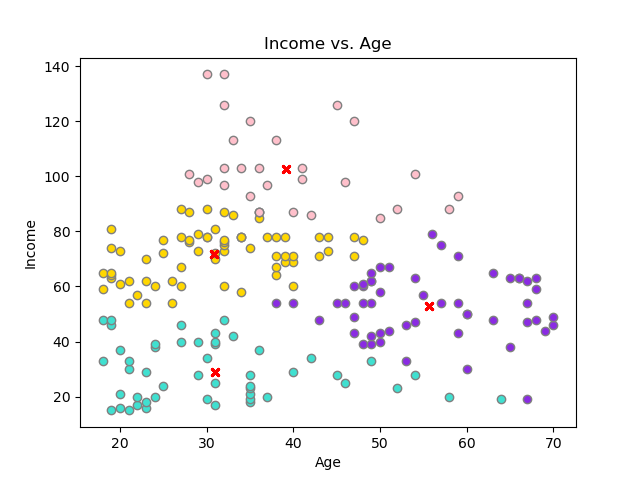

In [159]:
%matplotlib notebook

fig = plt.figure()

ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

### Step IV: Repeat II and III Until Convergence
We repeat calculation of cluster means, placement of centroids, and reassignment of member points to clusters until centroid locations fail to change by a specified threshold. 

In [160]:
MAX_ITERATIONS = 20

# Centroid will, at first, be located at the random, initialized locations.
centroids_x = initial_centroids_x
centroids_y = initial_centroids_y

for i in range(MAX_ITERATIONS):
    clusters = make_clusters(x, y, centroids_x, centroids_y, d)
    # Add a function here to pull data points for one centroid at a time - to feed into plot_clusters
    plot_clusters(clusters, centroids_x, centroids_y)
    centroids_x, centroids_y = make_centers(clusters)
    # print(centroids_x, centroids_y)
    

In [161]:
clusters.keys()

dict_keys([(31.02, 29.06), (55.666666666666664, 52.888888888888886), (30.863636363636363, 71.63636363636364), (39.2, 102.5)])

In [162]:
# BACKUP of plot_clusters
# def plot_clusters(clusters, centroids_x, centroids_y): # TODO: output of get_individual_cluster will output a key, val pair
#     """
#     Plots data as assigned to different clusters (demarcated with differing colors), and cluster centroids.

#     Args:
#         output_of_get_individual_cluster (key, val): should be a coord of form (x, y). Keep i, replace 'for coord in...'

#     Returns:
#         None 
        
#     """
#     colors = ['turquoise', 'blueviolet', 'gold', 'pink'] # TODO: update with more colors in case of k > 4.
#     figure(facecolor='w')

#     i = 0
    
#     for i in range(k): # TODO: this function should only plot. Make separate function to pull coords
#         for coord in clusters[centroids_x[i], centroids_y[i]]: # Goal: to plot each guardian centroid's points in a separate color
#             # print('Coord (member data pt):',coord, 'type:', type(coord)) # Input should be data points for ONE centroid
#             # print('Guardian centroid coords:', k_x[i], ',', k_y[i]) # This can be parsed out before plot fn is called          
#             plt.scatter(coord[0], coord[1], color=colors[i], edgecolor='grey')
#             # plt.scatter(centers[i][0], centers[i][1], s= 30, color = 'red', marker='x')
#             plt.scatter(centroids_x[i], centroids_y[i], s= 30, color = 'red', marker='x')
         
#     plt.title('Age vs. Income')
#     plt.show()
